<a href="https://colab.research.google.com/github/kanalive/notebooks/blob/main/RBA_data_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyLDAvis

#Import packages

In [2]:
# Mount Driver
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/MyDrive/notebooks') # Insert your complete path here, use \ if you have spaces in the path name

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import WordPunctTokenizer,sent_tokenize, word_tokenize
from nltk.data import LazyLoader
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from utils.corpusutils import CorpusPreProcess, Document, Corpus
from utils.featureutils import FeatureProcessor,find_closest



from sklearn.metrics.pairwise import cosine_similarity

from datetime import datetime
import pandas as pd
import os
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Configs


In [6]:
directory_path = "/content/drive/MyDrive/notebooks/RBAMeetingMins/"
similarity_thredhold = 0.6

#Functions

In [7]:
def preprocess(doc):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    sentences = sent_tokenize(doc)
    preprocessed = [ ' '.join(ps.stem(w.lower()) for w in word_tokenize(sent) if not w in stop_words and w.isalnum()) for sent in sentences]
    return sentences, preprocessed

def compare_docs(document1, document2, similarity_threshold=0.5):
    print("comparing document:")
    print(document1[:20])
    print(document2[:20])
    # Preprocessing
    original_sentences1, sentences1 = preprocess(document1)
    original_sentences2, sentences2 = preprocess(document2)

    # Vectorization
    vectorizer = TfidfVectorizer().fit_transform(sentences1 + sentences2)

    # Compute similarity
    similar_sentences = []
    similarity_scores = {}

    for i in range(len(sentences1)):
        for j in range(len(sentences2)):
            similarity = cosine_similarity(vectorizer[i:i+1], vectorizer[len(sentences1)+j:len(sentences1)+j+1])
            similarity_scores[(original_sentences1[i], original_sentences2[j])] = similarity[0][0]
            if similarity > similarity_threshold:
                similar_sentences.append((original_sentences1[i], original_sentences2[j], similarity[0][0]))

    # Identify added and removed sentences
    added_sentences = [s for s in original_sentences2 if all(similarity_scores.get((sent1, s), 0) < similarity_threshold for sent1 in original_sentences1)]
    removed_sentences = [s for s in original_sentences1 if all(similarity_scores.get((s, sent2), 0) < similarity_threshold for sent2 in original_sentences2)]

    return similar_sentences, added_sentences, removed_sentences


In [8]:
def read_txt_file_from_drive(file_path):
    text = ""

    if file_path.endswith(".txt"):
      with open(file_path, 'r') as file:
          text = file.read()

    return text

def read_txt_files_from_drive(directory):
    # List to store the content of each text file
    contents = []

    # Go through each file in the directory
    for filename in os.listdir(directory):
        # If the file is a .txt file
        if filename.endswith(".txt"):
            # Create the full file path by joining the directory path and the filename
            file_path = os.path.join(directory, filename)

            # Open the file and read the contents
            with open(file_path, 'r') as file:
                text = file.read()

            # Append the file contents to the list
            contents.append(text)

    return contents

In [9]:
# Function to extract date from filename
def get_date(filename):
    date_str = filename[:-4] # Remove the .txt part
    return datetime.strptime(date_str, '%Y%m%d')

In [10]:
import os
import datetime

def rename_files(directory_path):
    for filename in os.listdir(directory_path):
        # Get file extension
        _, file_extension = os.path.splitext(filename)
        if file_extension == '.txt':
            # Check the filename format
            try:
                # If it's in "ddmmyyyy" format
                date = datetime.datetime.strptime(filename[:8], "%d%m%Y")
            except ValueError:
                try:
                    # If it's in "yyyy-mm-dd" format
                    date = datetime.datetime.strptime(filename[:10], "%Y-%m-%d")
                except ValueError:
                    continue  # Not a date, skip this file

            # Convert date to "yyyymmdd" format
            new_filename = date.strftime("%Y%m%d") + '.txt'

            # Rename the file
            os.rename(os.path.join(directory_path, filename), os.path.join(directory_path, new_filename))



#LDA

In [ ]:
#if file names messed up again
#rename_files(directory_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
current_directory = os.getcwd()
root = directory_path
print(root)
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = LazyLoader("tokenizers/punkt/english.pickle")
category_pattern = r'(\d{4})/*'
file_extension = r'*.txt'
file_pattern = r'(\d{8})/*'
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') + list(string.punctuation) + ['u','.','s','--','-','."',',"','.)',')-','".','—','),']


rba_statements = CorpusPreProcess(root=root,file_extension = file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer = word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer = stemmer,
                            lemmatizer = lemmatizer,
                            stop_words = stop_words
                            )

/content/drive/MyDrive/notebooks/RBAMeetingMins/


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rba_statements

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
statement_ids = rba_statements.get_file_ids()

print('Total number of files: '+str(len(statement_ids)))
print('Number of paragraphs: '+str(len(rba_statements.get_paras())))
print('Number of sentences: '+str(len(rba_statements.get_sents())))
print('Number of words: '+str(len(rba_statements.get_words())))
print('\n'+'First file: '+ statement_ids[0])
print('Last file: '+ statement_ids[-1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total number of files: 180
Number of paragraphs: 180
Number of sentences: 23066
Number of words: 646073

First file: 20061003
Last file: 20221206


In [ ]:
#we can use lemmatization in tokenizer
#but tokenizer is done before stop word removal
paras = rba_statements.get_paras(flatten=True,stem=True)
def return_self(x):return x

vectorizer = CountVectorizer(tokenizer=return_self,lowercase=False,preprocessor=return_self)
bag_of_words = vectorizer.fit_transform((doc.stem for doc in paras))

num_topics = 6

lda_model = LatentDirichletAllocation(n_components = num_topics,
                                    max_iter = 20,
                                    #doc_topic_prior = 0.5,
                                    learning_method = 'online',
                                    random_state =10,
                                    n_jobs=-1)

lda_transform = lda_model.fit_transform(bag_of_words)

def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()

    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words

    return topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
## What are the most frequently used words
term_counts = {i:j for i,j in zip(vectorizer.get_feature_names_out(),bag_of_words.toarray().sum(axis=0))}
df_term_counts = pd.DataFrame(sorted(term_counts.items(),key=lambda x:x[1],reverse=True),columns=['term','count'])
df_term_counts.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,term,count
0,growth,5659
1,rate,5117
2,market,4905
3,member,4671
4,year,3851


In [ ]:
df_results = summarize_topics(lda_model,vectorizer.get_feature_names_out(),10)
df_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,growth,member,member,growth,rate,growth
1,rate,rate,growth,member,increas,rate
2,market,market,rate,increas,inflat,market
3,member,bank,market,expect,member,bank
4,year,would,year,rate,price,member
5,price,expect,price,price,market,expect
6,remain,economi,remain,year,expect,month
7,increas,increas,per,market,growth,cent
8,expect,bond,polici,per,economi,recent
9,per,remain,note,month,remain,year


In [ ]:
#Dictionary with topivs
topic_dict = {0 : 'Topic0',
              1 : 'Topic1',
              2 : 'Topic2',
              3 : 'Topic3',
              4 : 'Topic4',
              5 : 'Topic5',
              }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Topic proportions overtime


In [ ]:
categories = pd.Series([p.category_id for p in paras])
count = 0
year_prop = {}
for idx,year in categories[~(categories==categories.shift(-1))].items():
    c = lda_transform[count:count+int(idx)]
    year_prop[int(year)] = 100*(c.sum(axis=0)/c.sum())
    count = idx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

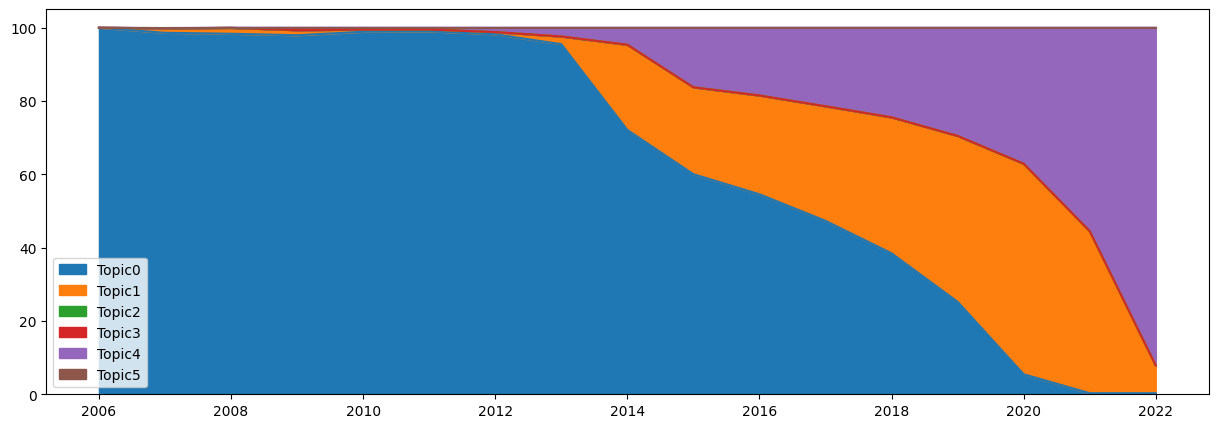

In [ ]:
yearly_prop = pd.DataFrame(year_prop).T.sort_index()
yearly_prop.columns = yearly_prop.columns.map(topic_dict)
yearly_prop.plot(kind='area',stacked=True,figsize=(15,5))

#Read RBA Statements data & Compare month by month

In [ ]:
def compare_two_statements(file1_name, file2_name):

  file1 = read_txt_file_from_drive(directory_path + file1_name)
  file2 = read_txt_file_from_drive(directory_path + file2_name)

  similar_sentences, added_sentences, removed_sentences = compare_docs(file1, file2,similarity_thredhold)

  comparison_date_1 = get_date(file1_name)
  comparison_date_2 = get_date(file2_name)

  ssdf = pd.DataFrame(similar_sentences, columns= ["Sentence1", "Sentence2", "SimilarityScore"])
  asdf = pd.DataFrame(added_sentences, columns=["AddedSentence"])
  rsdf = pd.DataFrame(removed_sentences, columns= ["RemovedSentence"])

  ssdf["comparison_date_1"] = comparison_date_1
  asdf["comparison_date_1"] = comparison_date_1
  rsdf["comparison_date_1"] = comparison_date_1

  ssdf["comparison_date_2"] = comparison_date_2
  asdf["comparison_date_2"] = comparison_date_2
  rsdf["comparison_date_2"] = comparison_date_2

  return ssdf, asdf, rsdf

In [ ]:
filenames = os.listdir(directory_path)

sdf_columns = ["Sentence1", "Sentence2", "SimilarityScore", "ComparisonDate1","ComparisonDate2"]
adf_columns = ["AddedSentence", "ComparisonDate1","ComparisonDate2"]
rdf_columns = ["RemovedSentence", "ComparisonDate1","ComparisonDate2"]

similar_df = pd.DataFrame(columns=sdf_columns)
added_df = pd.DataFrame(columns=adf_columns)
removed_df = pd.DataFrame(columns=rdf_columns)

for i, filename in enumerate(filenames):
    if i<len(filenames)-1:
      ssdf, asdf, rsdf = compare_two_statements(filename, filenames[i+1])
      ssdf.columns = sdf_columns
      asdf.columns = adf_columns
      rsdf.columns = rdf_columns

      similar_df = pd.concat([similar_df, ssdf])
      added_df = pd.concat([added_df, asdf])
      removed_df = pd.concat([removed_df, rsdf])



comparing document:
7 November 2007
At i
5 December 2007
At i
comparing document:
5 December 2007
At i
2 December 2008
At i
comparing document:
2 December 2008
At i
4 November 2008
At i
comparing document:
4 November 2008
At i
7 October 2008
At it
comparing document:
7 October 2008
At it
5 August 2008
At its
comparing document:
5 August 2008
At its
2 September 2008
At 
comparing document:
2 September 2008
At 
1 July 2008
At its m
comparing document:
1 July 2008
At its m
3 June 2008
At its m
comparing document:
3 June 2008
At its m
6 May 2008
At its me
comparing document:
6 May 2008
At its me
1 April 2008
At its 
comparing document:
1 April 2008
At its 
4 March 2008
At its 
comparing document:
4 March 2008
At its 
1 December 2009
At i
comparing document:
1 December 2009
At i
5 February 2008
At i
comparing document:
5 February 2008
At i
3 November 2009
At i
comparing document:
3 November 2009
At i
6 October 2009
At it
comparing document:
6 October 2009
At it
1 September 2009
At 
comparin

In [ ]:
similar_df[similar_df["ComparisonDate1"] == datetime.strptime("2008-02-05", "%Y-%m-%d")]


,Sentence1,Sentence2,SimilarityScore,ComparisonDate1,ComparisonDate2
0,"5 February 2008\nAt its meeting today, the Boa...","3 November 2009\nAt its meeting today, the Boa...",0.606418,2008-02-05,2009-11-03


In [ ]:
added_df[added_df["ComparisonDate1"] == datetime.strptime("2008-02-05", "%Y-%m-%d")]


,AddedSentence,ComparisonDate1,ComparisonDate2
0,The global economy has resumed growth.,2008-02-05,2009-11-03
1,With economic policy settings likely to remain...,2008-02-05,2009-11-03
2,The expansion is generally expected to be mode...,2008-02-05,2009-11-03
3,Prospects for Australia's Asian trading partne...,2008-02-05,2009-11-03
4,"Growth in China has been very strong, which is...",2008-02-05,2009-11-03
5,"For Australia's trading partner group, growth ...",2008-02-05,2009-11-03
6,Sentiment in global financial markets is much ...,2008-02-05,2009-11-03
7,"Nonetheless, the state of balance sheets in so...",2008-02-05,2009-11-03
8,Economic conditions in Australia have been str...,2008-02-05,2009-11-03
9,Some spending has probably been brought forwar...,2008-02-05,2009-11-03


#Compile all sentences and assign hawkish dovish score

In [ ]:
list_sentences = read_txt_files_from_drive(directory_path)
list_s = []
list_preprocessed_s = []
for s in list_sentences:
  sentences, preprocessed = preprocess(s)
  list_s.append(sentences)
  list_preprocessed_s.append(preprocessed)

merged_list = [item for sublist in list_s for item in sublist]
distinct_list = list(set(merged_list))

In [ ]:
rba_statement_senteces = pd.DataFrame(distinct_list, columns = ["Sentence"])

In [ ]:
df_filtered = rba_statement_senteces[rba_statement_senteces['Sentence'].str.contains('wage growth', case=False, na=False)]
df_filtered

,Sentence
110,"Wage growth remains low, however, and this is ..."
590,"Notwithstanding the improving labour market, w..."
627,"Wage growth remains subdued in most countries,..."
1136,Wage growth remains slow and this is likely to...
1489,"Consistent with this, the rate of wage growth ..."
1622,"Against this, however, wage growth remains low..."
1865,"This is likely to continue for a while yet, al..."
1973,"However, wage growth remains low."
2162,Wage growth remains slow.
2809,"Wage growth remains low in most countries, as ..."


#Use OpenAI API to determine Hawkish score

In [11]:
df_data = pd.read_csv("/content/drive/MyDrive/notebooks/openai_sentiment_data/hawkish_score.csv")

In [15]:
df_data[df_data["HawkishScore"]==0]

,Id,Date,Sentence,ProcessedSentence,HawkishScore
0,0,7/11/2007,"7 November 2007\nAt its meeting yesterday, the...",7 novemb 2007 at meet yesterday board decid in...,0.0
11,11,7/11/2007,Conditions have improved over the past couple ...,condit improv past coupl month confid remain f...,0.0
12,12,7/11/2007,Funding costs for intermediaries remain elevat...,fund cost intermediari remain elev rel offici ...,0.0
13,13,7/11/2007,This is likely to result in some moderation in...,thi like result moder growth countri 2008 fore...,0.0
14,14,7/11/2007,The world economy is still expected to grow at...,the world economi still expect grow pace howev...,0.0
...,...,...,...,...,...
4630,4630,4/04/2023,"A range of information, including the monthly ...",a rang inform includ monthli cpi indic suggest...,0.0
4631,4631,4/04/2023,Goods price inflation is expected to moderate ...,good price inflat expect moder month ahead due...,0.0
4640,4640,4/04/2023,The unemployment rate is at a near 50-year low...,the unemploy rate near low underemploy also low,0.0
4651,4651,4/04/2023,The Board expects that some further tightening...,the board expect tighten monetari polici may w...,0.0


In [16]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.3 MB/s eta 0:00:00


In [37]:
df_zero_score = df_data[df_data["HawkishScore"]==0]

In [38]:
df_zero_score

,Id,Date,Sentence,ProcessedSentence,HawkishScore
0,0,7/11/2007,"7 November 2007\nAt its meeting yesterday, the...",7 novemb 2007 at meet yesterday board decid in...,0.0
11,11,7/11/2007,Conditions have improved over the past couple ...,condit improv past coupl month confid remain f...,0.0
12,12,7/11/2007,Funding costs for intermediaries remain elevat...,fund cost intermediari remain elev rel offici ...,0.0
13,13,7/11/2007,This is likely to result in some moderation in...,thi like result moder growth countri 2008 fore...,0.0
14,14,7/11/2007,The world economy is still expected to grow at...,the world economi still expect grow pace howev...,0.0
...,...,...,...,...,...
4630,4630,4/04/2023,"A range of information, including the monthly ...",a rang inform includ monthli cpi indic suggest...,0.0
4631,4631,4/04/2023,Goods price inflation is expected to moderate ...,good price inflat expect moder month ahead due...,0.0
4640,4640,4/04/2023,The unemployment rate is at a near 50-year low...,the unemploy rate near low underemploy also low,0.0
4651,4651,4/04/2023,The Board expects that some further tightening...,the board expect tighten monetari polici may w...,0.0


In [46]:
def concatenate_sentences(df, num_sentences=100):
    sentence_batches = []
    batch = ""
    for index, row in df.iterrows():
        sentence = f"{row['Id']}. {row['Sentence']}\n"
        if len(batch.split("\n")) < num_sentences:
            batch += sentence
        else:
            sentence_batches.append(batch)
            batch = sentence
    # Add the remaining sentences in the last batch
    if batch:
        sentence_batches.append(batch)
    return sentence_batches

sentence_batches = concatenate_sentences(df_zero_score)

sentence_batches[0]

"0. 7 November 2007\nAt its meeting yesterday, the Board decided to increase the cash rate by 25 basis points to 6.75 per cent.\n11. Conditions have improved over the past couple of months, but confidence remains fragile.\n12. Funding costs for intermediaries remain elevated relative to official interest rates, and capital market conditions are still difficult, in several major countries.\n13. This is likely to result in some moderation in growth in those countries in 2008, and forecasts for global growth have been revised down accordingly.\n14. The world economy is still expected to grow at an above-average pace, however, led by strong growth in China and other parts of Asia.\n15. High global commodity prices remain an important source of stimulus to Australian spending and activity.\n16. In Australia, the tightening in credit conditions resulting from the global turmoil has been less pronounced than elsewhere.\n17. Wholesale funding costs have risen a little compared with official ra

In [55]:
import openai
import json
from typing import List
import re


OPEN_AI_API_KEY = ""

file_path = "/content/drive/MyDrive/keys/keys.json"
with open(file_path, 'r') as file:
  loaded_object = json.load(file)
  OPEN_AI_API_KEY = loaded_object["OPEN_AI_API_KEY"]

openai.api_key = OPEN_AI_API_KEY

def get_hawkish_score(sentences: pd.DataFrame):

    scores = []

    for text in sentences:
        prompt = f"{text}\nPlease analyze the the hawkish/dovish sentiment of each sentence from Australian Central Bank, give it a score from 1-10. 1 being most dovish, 10 being the most hawkish. Please respond in the format of <number.><original sentence> - <score> linebreak"

        response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=prompt,
            max_tokens=1000,
            temperature=0.3,
        )
        # Parse the response and store the scores.
        for line in response.choices[0].text.strip().split("\n"):
            print(line)
            # if "-" in line and re.search(r'\d\.', line):
            #     id, score = line.split(". ")[0], line.split(" - ")[1]
            #     scores.append((id, score))
            # else:
            #     print("not the right format")



    return scores


get_hawkish_score(sentence_batches[0])

Sentence ID: 0, Hawkish Score: 8
Sentence ID: 1, Hawkish Score: 3
